In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torcheval.metrics import R2Score

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import ast

import loss_landscapes
import loss_landscapes.metrics

import utils

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [5]:
variable = "delaney-processed"

clustered_data_file = "data/clustered_%s.csv"%variable

df = pd.read_csv(clustered_data_file)

# Splitting dataset into In-Distribution (ID) training and testing sets
#temp_ID_X = np.asarray(df[df['Cluster']==0]['EMBEDDINGS'].tolist(), dtype=np.float32)
temp_ID_X = [ast.literal_eval(a) for a in df[df['Cluster']==0]['EMBEDDINGS'].tolist()]

temp_ID_Y = np.asarray(df[df['Cluster']==0]['Y'], dtype=np.float32)
x_train, x_test_ID, y_train, y_test_ID  = train_test_split(temp_ID_X, temp_ID_Y, train_size=0.7, random_state=1993)

In [6]:
class RBF(nn.Module):
    def __init__(self, num_centers, input_dim, gamma=1.0):
        super(RBF, self).__init__()
        self.num_centers = num_centers
        self.input_dim = input_dim
        self.gamma = gamma

        self.centers = nn.Parameter(torch.randn(num_centers, input_dim))

    def forward(self, x):
        distances = torch.cdist(x, self.centers) ** 2
        return torch.exp(-self.gamma * distances)

class SVR(nn.Module):
    def __init__(self, input_dim, num_centers, gamma=1.0):
        super(SVR, self).__init__()
        self.rbf = RBF(num_centers, input_dim, gamma)
        self.linear = nn.Linear(num_centers, 1)

    def forward(self, x):
        x = self.rbf(x)
        x = self.linear(x)
        return x

In [10]:
# Create sample data
X = torch.tensor(x_train)
y = torch.tensor(y_train)
y = y.reshape(len(y_train), 1)

# Model parameters
input_dim = 512 
num_centers = 10
gamma = 1 / (512 * X.var()) 

model = SVR(input_dim, num_centers, gamma)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)



# Training loop
for epoch in range(30000):
    # Generate some sample data
    #x = torch.randn(32, input_dim)
    #y = torch.randn(32, 1)

    optimizer.zero_grad()
    y_pred = model(X)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    
    if epoch % 2000 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

Epoch: 0, Loss: 9.433164596557617
Epoch: 2000, Loss: 0.5408454537391663
Epoch: 4000, Loss: 0.2976251244544983
Epoch: 6000, Loss: 0.20401979982852936
Epoch: 8000, Loss: 0.15708144009113312
Epoch: 10000, Loss: 0.12746769189834595
Epoch: 12000, Loss: 0.10469341278076172
Epoch: 14000, Loss: 0.09068939834833145
Epoch: 16000, Loss: 0.08025413751602173
Epoch: 18000, Loss: 0.07217265665531158
Epoch: 20000, Loss: 0.06550530344247818
Epoch: 22000, Loss: 0.06002533808350563
Epoch: 24000, Loss: 0.059110671281814575
Epoch: 26000, Loss: 0.05173483118414879
Epoch: 28000, Loss: 0.047942474484443665


In [11]:
# Get all the model parameters
params = [p for p in model.parameters()]

In [12]:
params

[Parameter containing:
 tensor([[-0.1395,  0.3628, -0.6688,  ..., -0.1032,  0.1700, -0.5265],
         [ 0.0387, -0.2340,  0.3413,  ..., -0.1517, -0.4159, -0.1067],
         [ 0.3115, -0.1239, -0.2335,  ..., -0.3375,  0.3012,  0.1531],
         ...,
         [-0.0527,  0.0281, -0.0709,  ..., -0.0450,  0.0723,  0.0566],
         [ 0.3543, -0.2981,  0.2077,  ..., -0.6525,  1.4742,  0.3256],
         [-0.3184, -0.1807,  0.3282,  ..., -0.6624, -0.0711, -1.0406]],
        requires_grad=True),
 Parameter containing:
 tensor([[-31.1433, -36.0068, -39.5835, -20.7248, -43.9962, -49.2654, -34.0630,
           48.1614, -50.4507, -33.0816]], requires_grad=True),
 Parameter containing:
 tensor([0.4337], requires_grad=True)]

In [17]:
# Calculate the standard deviation of all parameters
wt_std = torch.std(torch.cat([p.view(-1) for p in params]))

DISTANCE=10*wt_std.cpu().detach().numpy()

print(DISTANCE)

18.137974739074707


In [18]:
perturbation_range = np.round(np.linspace(-0.5*DISTANCE, 0.5*DISTANCE, 8), 3)

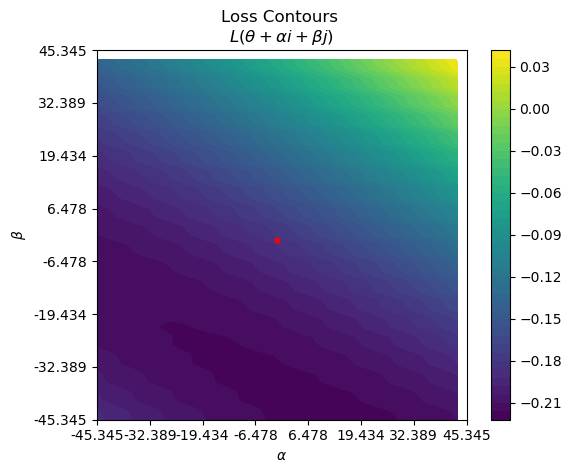

In [19]:
X_test_ID_tensor = torch.tensor(x_test_ID)
y_test_ID_tensor = torch.tensor(y_test_ID)
y_test_ID_tensor_reshaped = y_test_ID_tensor.reshape(len(y_test_ID), 1)

model.eval()
y_pred_ID_tensor = model(X_test_ID_tensor)

#x, y = iter(test_loader).__next__()

metric = loss_landscapes.metrics.Loss(criterion, X_test_ID_tensor, y_test_ID_tensor_reshaped)

# contour plot resolution
STEPS=40

loss_data_fin = loss_landscapes.random_plane(model.cpu(), metric, distance=DISTANCE*5, steps=STEPS, normalization='filter', deepcopy_model=True)

utils.plot_loss_contours(loss_data=loss_data_fin, steps=STEPS, distance=DISTANCE*5, save_fig=True)

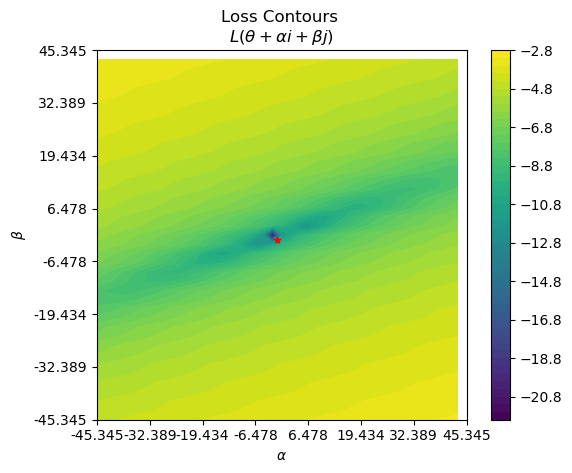

In [21]:
x_test_OOD = [ast.literal_eval(a) for a in df[df['Cluster']==-1]['EMBEDDINGS'].tolist()]
y_test_OOD = np.asarray(df[df['Cluster']==-1]['Y'], dtype=np.float32)

X_test_OOD_tensor = torch.tensor(x_test_OOD)
y_test_OOD_tensor = torch.tensor(y_test_OOD)
y_test_OOD_tensor_reshaped = y_test_OOD_tensor.reshape(len(y_test_OOD), 1)

model.eval()
y_pred_OOD_tensor = model(X_test_OOD_tensor)

metric = loss_landscapes.metrics.Loss(criterion, X_test_OOD_tensor, y_pred_OOD_tensor)

# contour plot resolution
STEPS=40

loss_data_fin = loss_landscapes.random_plane(model.cpu(), metric, distance=DISTANCE*5, steps=STEPS, normalization='filter', deepcopy_model=True)

utils.plot_loss_contours(loss_data=loss_data_fin, steps=STEPS, distance=DISTANCE*5, save_fig=True)